# Section 1: Business Understanding
During the initial outbreak of the global COVID-19 pandemic in spring 2020, gaming swiftly emerged as one of the most popular activities, with user involvement and spending skyrocketing between February and April of that year. Today, gaming become the part of life for several people and the popularity seem to rise up continuously. I attempt to find insight regarding video games and scores through the questions below:

### Question 1: What platform sold best games?

### Question 2: What drive sales of video games?

### Question 3: Are there any differences between users and critics?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

# Section 2: Data Understanding

In [2]:
df = pd.read_csv(r'..\Video_Games.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       10015 non-null  object 
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


In [4]:
df.shape

(16719, 16)

In [5]:
df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# convert columns name to lower case for ease of use
df.columns = df.columns.str.lower()

In [7]:
# drop sales other than global sales
df.drop(columns=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'], inplace=True)

In [8]:
# replace tbd value to NAN
df.replace('tbd', np.nan, inplace=True)

In [9]:
# convert str to float
df['user_score'] = df['user_score'].astype('float')

In [10]:
# scaling user score to be compare with critic score
df['user_score'] = df['user_score'] * 10

In [11]:
# mapping platform to major platform
cat_map = {'PS':'PS', 'PS2':'PS', 'PS3':'PS', 'PS4':'PS', 'PSV':'PS', 'PSP':'PS', 'DS':'Nintendo', 'Wii':'Nintendo', 'GBA':'Nintendo',
          'GC':'Nintendo', '3DS':'Nintendo', 'SNES':'Nintendo', 'N64':'Nintendo', 'WiiU':'Nintendo', 'NES':'Nintendo', 'GB':'Nintendo',
          'X360':'Microsoft', 'XB':'Microsoft', 'XOne':'Microsoft', 'PC':'PC'}

### Exploratory Data Analysis

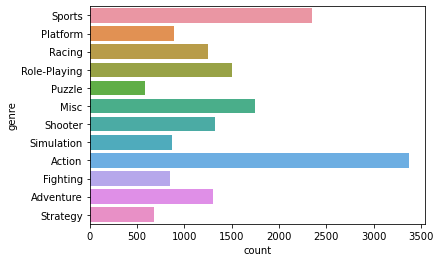

In [12]:
sns.countplot(y='genre', data=df);

Action is the most popular genre.

In [13]:
df['major_platform'] = df['platform'].map(cat_map)

In [14]:
# drop row with missing score for analysis
df_clean = df.dropna(subset=['critic_score', 'user_score'], how='any')

In [15]:
df.major_platform.value_counts()

PS           6723
Nintendo     6271
Microsoft    2333
PC            974
Name: major_platform, dtype: int64

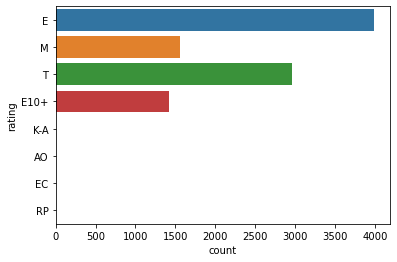

In [16]:
sns.countplot(y='rating', data=df);

In [17]:
# group by name to calculate global sales with cross-platform games
top_selling = df.groupby('name')['global_sales'].sum().sort_values(ascending=False).head(10)

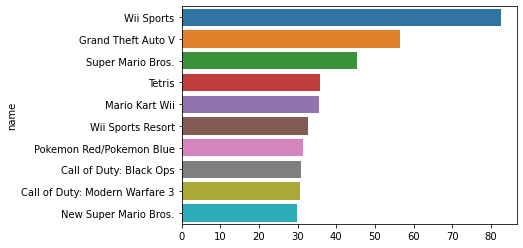

In [18]:
sns.barplot(y=top_selling.index, x=top_selling.values);

Will Sports is the best-selling games as of 2016.

In [19]:
median_critic = df_clean.groupby('major_platform')['critic_score'].median().drop('PC')

In [20]:
median_sales = df_clean.groupby('major_platform')['global_sales'].median().drop('PC')

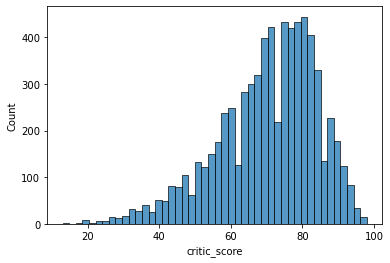

In [21]:
sns.histplot(x='critic_score', data=df_clean);

Critic score is left-skewed so we use median as a proxy of the analysis

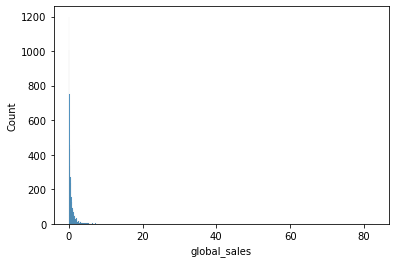

In [22]:
sns.histplot(x='global_sales', data=df_clean);

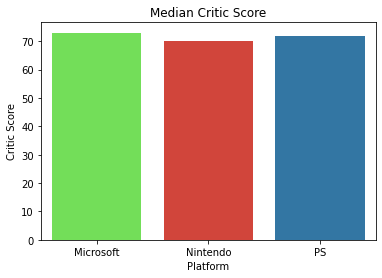

In [23]:
colors = ["#66f443", '#ea2f22', '#2079b6']
customPalette = sns.set_palette(sns.color_palette(colors))
sns.barplot(x=median_critic.index, y=median_critic, palette=customPalette)
plt.xlabel('Platform')
plt.ylabel('Critic Score')
plt.title('Median Critic Score')
plt.savefig('1.png');

Those 3 platforms are performing similarly in term of critic_score. However, there maybe the cross platform games that influence the result. Next, we will look at only platform exclusive game to determine who sells the best games.

In [24]:
exclusive_median = df_clean.drop_duplicates(subset='name', keep=False).groupby('major_platform')['critic_score'].median().drop('PC')

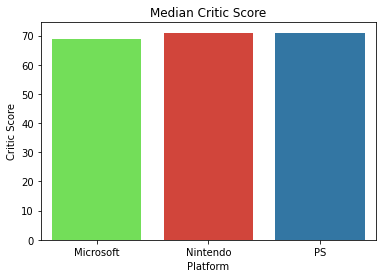

In [25]:
sns.barplot(x=exclusive_median.index, y=exclusive_median, palette=customPalette)
plt.xlabel('Platform')
plt.ylabel('Critic Score')
plt.title('Median Critic Score')
plt.savefig('2.png');

Seem like there is no different at all! 

In [26]:
# count only the exclusive game
exclusive_count = df_clean.drop_duplicates(subset='name', keep=False).query('critic_score >= 80')['major_platform'] \
.value_counts(normalize=True).sort_values().drop('PC')

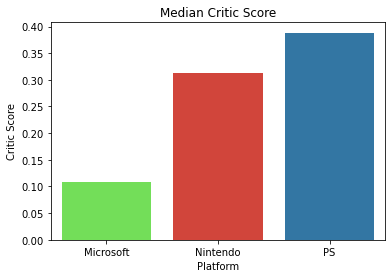

In [27]:
sns.barplot(x=exclusive_count.index, y=exclusive_count, palette=customPalette)
plt.xlabel('Platform')
plt.ylabel('Critic Score')
plt.title('Median Critic Score')
plt.savefig('3.png');

We now finally have a clear winner! The game that exclusively available for sony has the highest proportion of the good game. Nintendo is coming behind. and then Microsoft.

We see this in the aspect of critic score, but do this result implies in term of sales count. Next, we will try to determine the influence of critic score to sales count.

In [28]:
median_sales = df_clean.groupby('major_platform')['global_sales'].median()

In [29]:
# prepare the top 10 sales by platform
top_selling_by_plat = df.groupby('platform')['global_sales'].sum().sort_values(ascending=False).head(10)

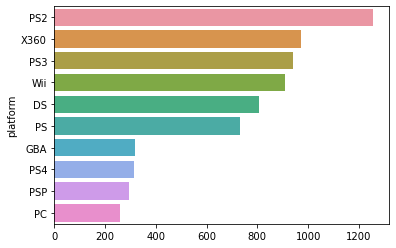

In [30]:
sns.barplot(y=top_selling_by_plat.index, x=top_selling_by_plat.values);

Seem like PS2 is the most popular console.

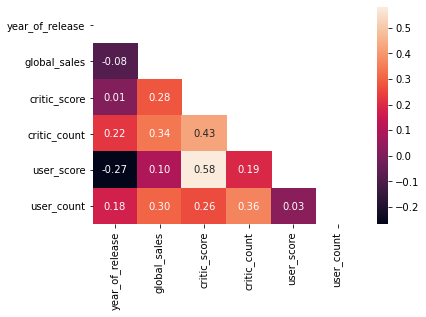

In [31]:
# plot correlation matrix
corr= df.corr()
matrix = np.triu(corr)
fig = sns.heatmap(df.drop(0, axis=0).corr(), annot=True, mask=matrix, fmt='.2f').get_figure()
fig.savefig('4.png', bbox_inches="tight");

Interstingly, there seem to be a strong correlation between user_score and critic_score. It's probable that user and critic have the same preference. Or there can hardly be any difference between these two groups at all. Note that this is just a intuition that straightly come right to my mind, we have to test our hypothesis via statistical method to confirm this intuition.

<AxesSubplot:xlabel='user_score', ylabel='critic_score'>

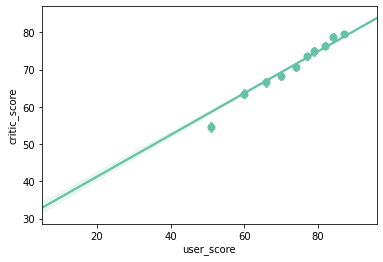

In [32]:
# plot regression line between user_score and critic_score
sns.set_palette(sns.color_palette("Set2"))
sns.regplot(x='user_score', y='critic_score', data=df, x_bins=10)

<AxesSubplot:xlabel='user_score', ylabel='global_sales'>

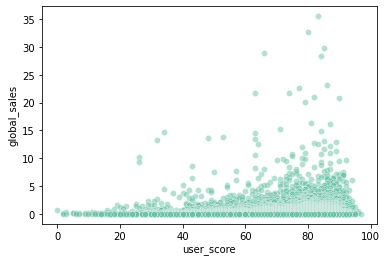

In [33]:
sns.scatterplot(x='user_score', y='global_sales', data=df.drop(0, axis=0), alpha=0.5)

<AxesSubplot:xlabel='user_score', ylabel='global_sales'>

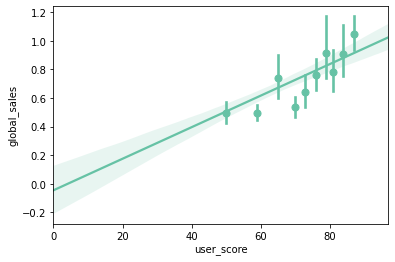

In [34]:
sns.regplot(x='user_score', y='global_sales', data=df, x_bins=10)

<AxesSubplot:xlabel='critic_score', ylabel='global_sales'>

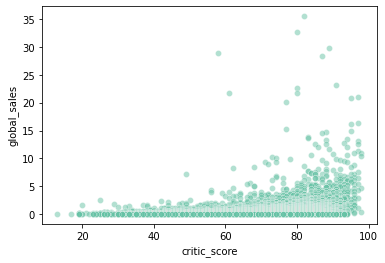

In [35]:
sns.scatterplot(x='critic_score', y='global_sales', data=df.drop(0, axis=0), alpha=0.5)

# Section 3: Data Preparation

Do critic score influence the sales of video games? It seem resonable to think so. People usually collects a lot of information before making a decision. What about the variety of genre, platform, or publisher? Do the customers prefer one over another? We will use a machine learning algorithm to answer these questions.

The model I attempt to create to predict sales of video games based on the following variables:
- Genre
- Platform of release
- Publisher
- Metacritic score
- Year of release
<br>

(I avoid using user related variables to prevent 'data leakage' problem)

In [48]:
def remove_low_publisher(df, thresh):
    '''
    INPUT:
        df - data to be clean
        thresh - number of games that specific publisher release
    OUTPUT:
        new_df - dataframe that drop the publisher that publishs the games lower than thresh
    '''
    new_df = df.drop(df[df.publisher.isin(df.publisher.value_counts()[df.publisher.value_counts() < thresh].index)].index, axis=0)
    return new_df

In [49]:
def train_test_prep(df):
    '''
    preprocess the data and split them to train and test set
    '''
    X = df[['platform', 'genre', 'publisher','critic_score']]
    y = df[['global_sales']]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
    
    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
    train_enc = ohe.fit_transform(X_train[['platform', 'genre', 'publisher']])
    test_enc = ohe.transform(X_test[['platform', 'genre', 'publisher',]])
    
    ohe_train = pd.DataFrame(train_enc, columns=ohe.get_feature_names(input_features=['platform', 'genre', 'publisher']))
    ohe_test = pd.DataFrame(test_enc, columns=ohe.get_feature_names(input_features=['platform', 'genre', 'publisher']))
    
    X_train_new = X_train.drop(columns=['platform', 'genre', 'publisher',])
    X_test_new = X_test.drop(columns=['platform', 'genre', 'publisher',])
    X_train = pd.concat([X_train_new.reset_index(), ohe_train.reset_index()], axis=1)
    X_test = pd.concat([X_test_new.reset_index(), ohe_test.reset_index()], axis=1)
    X_train.drop(columns='index', inplace=True)
    X_test.drop(columns='index', inplace=True)
    
    return X_train, X_test, y_train, y_test

# Section 4: Data Modeling

In [50]:
def fit_and_predict_model(X_train, X_test, y_train, y_test):
    '''
    Fitting the training data to the model, then predict both train and test set and print r2 and mae score
    '''
    xgb = XGBRegressor(random_state=42, subsample=0.7, n_estimators = 500, max_depth=10, learning_rate=0.01,
                       colsample_bytree=0.9, colsample_bylevel=0.8)
    xgb.fit(X_train, y_train)
    y_train_preds = xgb.predict(X_train)
    y_test_preds = xgb.predict(X_test)
    print(f'r2 train: {r2_score(y_train, y_train_preds)}')
    print(f'r2 test: {r2_score(y_test, y_test_preds)}')
    print(f'mae train: {mean_absolute_error(y_train, y_train_preds)}')
    print(f'mae test: {mean_absolute_error(y_test, y_test_preds)}')
    return xgb

In [51]:
# df_prep = remove_low_publisher(df_clean_1, 50)
X_train, X_test, y_train, y_test = train_test_prep(df_clean)
xgb = fit_and_predict_model(X_train, X_test, y_train, y_test)

r2 train: 0.8794481017875971
r2 test: 0.40824212097892876
mae train: 0.3544021824808317
mae test: 0.542945183025742


# Section 5: Evaluation

### Question 1: What platform sold best games?

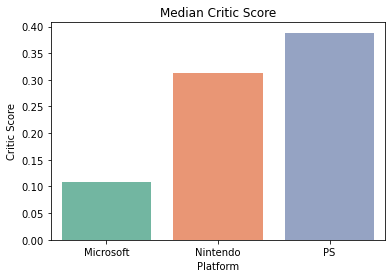

In [52]:
sns.barplot(x=exclusive_count.index, y=exclusive_count, palette=customPalette)
plt.xlabel('Platform')
plt.ylabel('Critic Score')
plt.title('Median Critic Score');

We found that PlayStation is the platform that sold the highest amount of exclusive games through observation on median Metacritic score.

### Question 2: What drive sales of video games?

In [53]:
shap.initjs()

In [54]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


After we successfully train our model. We will try to answer the question that what drives video game sales by understand the influence of specific variables on a prediction made.

In [55]:
df.iloc[2735]

name               Tony Hawk's Underground 2
platform                                  XB
year_of_release                       2004.0
genre                                 Sports
publisher                         Activision
global_sales                            0.75
critic_score                            83.0
critic_count                            55.0
user_score                              78.0
user_count                              12.0
developer            Neversoft Entertainment
rating                                     T
major_platform                     Microsoft
Name: 2735, dtype: object

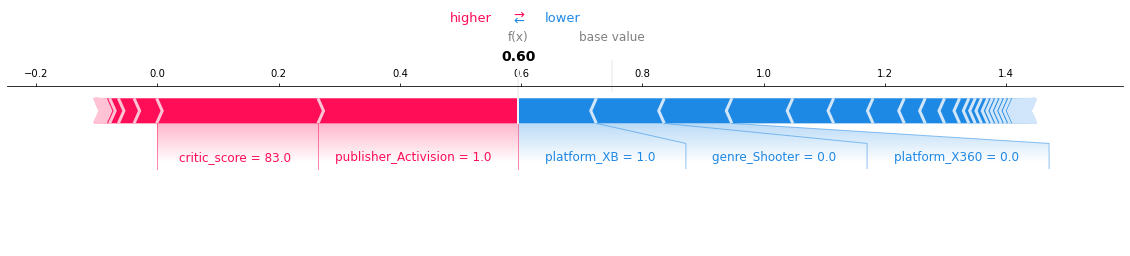

In [56]:
i = 3
shap.force_plot(explainer.expected_value, shap_values[i], features=X_train.iloc[i], feature_names=X_train.columns,
                matplotlib=True, show=False).savefig('shapforce.png', bbox_inches="tight")

The shapely force plot shows the impact of the variables on one specific example. (Here's the resource describe how shapley force plot work.) This one shows the prediction of the game called "Tony Hawk's Underground 2" in the XBOX platform. The way to interpret this graph is pretty simple. Pink color indicate feature that increase the target variable which is sales, and the blue color do the opposite. (FYI. 1 represent presence, 0 represent absence)

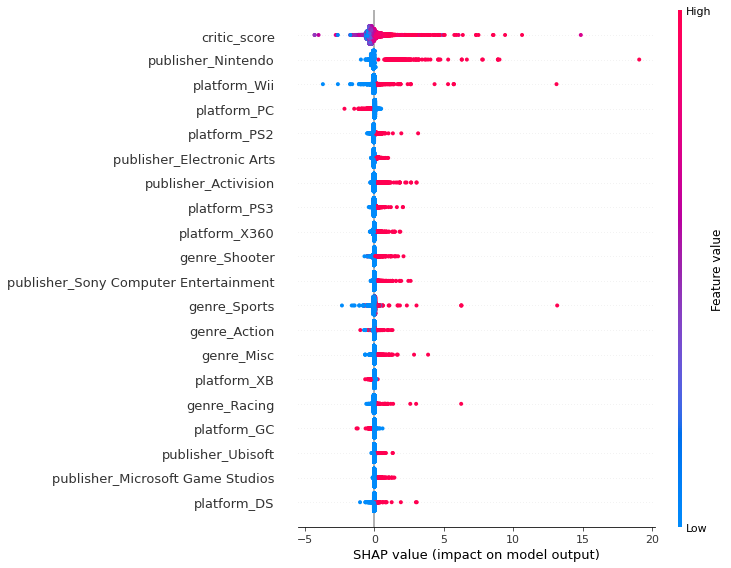

In [57]:
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns)

The chart below shows 20 most important features that influence the sales the most. Unsurprisingly, critic_score is the top of the list, as people decision usually depends on the internet reviews (including ME!).

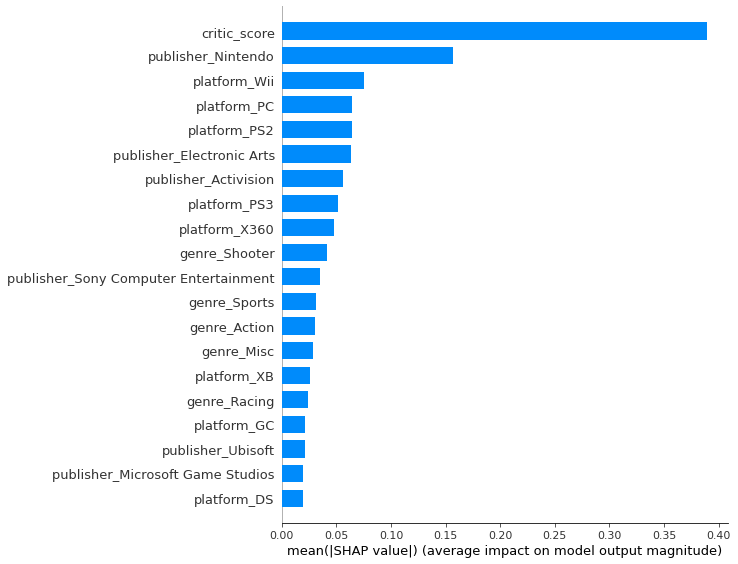

In [58]:
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns, plot_type='bar',  show=False)
plt.savefig('grafic.png', bbox_inches="tight");

### Question 3: Are there any differences between users and critics?

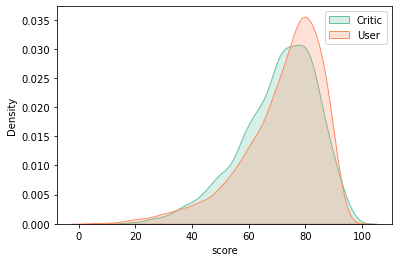

In [59]:
# plot kde plot to compare distribution between median critic and median user score
fig, axes = plt.subplots()
sns.kdeplot(x='critic_score', data=df[~(df.user_score.isna() | df.critic_score.isna())], fill=True, label='Critic', axes=axes)
sns.kdeplot(x='user_score', data=df[~(df.user_score.isna() | df.critic_score.isna())], fill=True, label= 'User', axes=axes)
axes.set_xlabel('score')
axes.legend()
fig.savefig('kde.png')

From the graph, we can see that both user_score and critic_score distribution are quite left-skewed. And seem like my intuition was wrong as the users on average give higher scores than critics. To be sure, we will perform bootstrap test for difference between means. I choose this method because it doesn't require a lot of assumptions like t-test and the test itself doesn't require much of the theory, so it's quite easy to understand. We can now state our Null and Alternative hypothesis as follows:
- H0: Mean differences between user_score and critic_score = 0
- H1: Mean differences between user_score and critic_score != 0

In [60]:
def bootstrap_mean(data):
    '''
    Compute bootstrap mean from the data provided
    '''
    bs_sample = np.random.choice(data, len(data))
    return np.mean(bs_sample)

In [61]:
# create array of user and critic score
user = df.user_score[~(df.user_score.isna() | df.critic_score.isna())].ravel() # drop missing value of both user and critic score
critic = df.critic_score[~(df.user_score.isna() | df.critic_score.isna())].ravel()

In [62]:
def draw_bs_reps(data, size):
    '''
    INPUT:
        data - data for analysis
        size - number of replications
    OUTPUT:
        bs_replicates - array with the mean of each bootstrap iteration
    '''
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_replicates[i] = bootstrap_mean(data)
    return bs_replicates

In [63]:
mean_score = np.mean(np.concatenate((user, critic), axis=None)) # compute mean of the group as if they're from the same population

user_shifted = user - np.mean(user) + mean_score
critic_shifted = critic - np.mean(critic) + mean_score # shift user and critic score to have the same mean

bs_replicates_user = draw_bs_reps(user_shifted, 100000)
bs_replicates_critic = draw_bs_reps(critic_shifted, 100000) # draw bootstrap replicates 100000 times


bs_replicates = bs_replicates_user - bs_replicates_critic # compute difference of the bootstrap mean between 2 groups

empirical_mean = np.mean(user) - np.mean(critic) # compute difference of the real mean between 2 groups

p = sum(bs_replicates >= empirical_mean) / len(bs_replicates) # test statistic
print('p-value =', p)

p-value = 0.0


The result is not surprising. We get the p-value of 0.0 from 100000 bootstrap replicates. So, we reject H0 and accept H1.

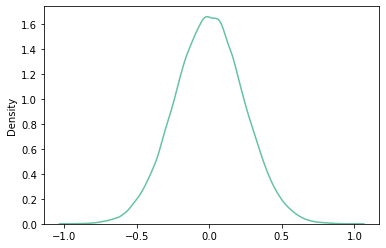

In [64]:
# plot the distribution of the shifted bootstrap mean
fig, axes = plt.subplots()
sns.kdeplot(bs_replicates);

In [65]:
mean_diff = draw_bs_reps(user - critic, 100000)

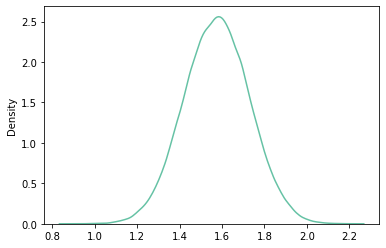

In [66]:
# plot the distribution of the empirical bootstrap mean
sns.kdeplot(mean_diff);

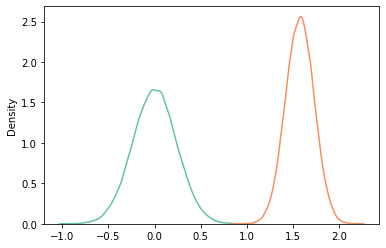

In [67]:
axes = sns.kdeplot(bs_replicates);
axes = sns.kdeplot(mean_diff);

The graph shows comparation of distribution of the empirical bootstrap mean and distribution of the empirical shifted mean. As we can see from the graph, majority of the area do not overlap with each other. So, we may reject H0 based on the observation. 

In [68]:
np.percentile(bs_replicates, [2.5, 97.5]) # compute 95% confidence interval

array([-0.47000499,  0.47085649])

In [69]:
np.percentile(mean_diff, [2.5, 97.5]) # # compute 95% confidence interval

array([1.27162605, 1.87786803])